# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings

In [2]:
POINTS = 500
BEST_FOR_ML = 200
BUDGET = 10e9
BARREL_PRICE = 450e3
THRESHOLD = 0.025

In [3]:
warnings.filterwarnings("ignore")

### Загрузка датасетов и проверка на пропуски

#### Первый регион

In [4]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
df_1.duplicated().sum()

0

In [8]:
df_1.id.value_counts().to_frame().head(15)

,id
bxg6G,2
HZww2,2
fiKDv,2
bsk9y,2
QcMuo,2
AGS9W,2
A5aEY,2
74z30,2
Tdehs,2
TtcGQ,2


In [9]:
df_1.drop(df_1[df_1.duplicated(subset='id')].index, inplace=True)

In [10]:
df_1.id.value_counts().to_frame().head(15)

,id
btzXu,1
gzBog,1
xCStY,1
Ei4qu,1
6ruUD,1
G3JTC,1
YqmAD,1
yc7So,1
BGsDy,1
oKnQ7,1


#### Второй регион

In [11]:
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
df_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [14]:
df_2.duplicated().sum()

0

In [15]:
df_2.id.value_counts().to_frame().head(15)

,id
LHZR0,2
5ltQ6,2
bfPNe,2
wt4Uk,2
HFhmk,1
v501o,1
6e6mX,1
4G2PU,1
GNYRK,1
eiu5z,1


In [16]:
df_2.drop(df_2[df_2.duplicated(subset='id')].index, inplace=True)

In [17]:
df_2.id.value_counts().to_frame().head()

,id
HFhmk,1
yuo5f,1
d2Crc,1
6e6mX,1
4G2PU,1


#### Третий регион

In [18]:
df_3 = pd.read_csv('/datasets/geo_data_2.csv')
df_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [19]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [20]:
df_3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [21]:
df_3.duplicated().sum()

0

In [22]:
df_3.id.value_counts().to_frame().head(15)

,id
Vcm5J,2
KUPhW,2
VF7Jo,2
xCHr8,2
TDsuX,1
nezj4,1
6Gpne,1
D4tDZ,1
WdPIv,1
H43mY,1


In [23]:
df_3.drop(df_3[df_3.duplicated(subset='id')].index, inplace=True)

In [24]:
df_3.id.value_counts().to_frame().head()

,id
TDsuX,1
0KxWH,1
D4tDZ,1
WdPIv,1
H43mY,1


Пропусков не обнаружено, все столбцы соответствуют типам данных.

### Распределения признаков

In [25]:
def show_hists(data, data_label, num_bins):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(15, 3))
    axes[0].set_title(data_label + ". Гистограмма распределения", fontsize=18)
    axes[0].set_ylabel('количество', fontsize=15)
    sns.histplot(data, bins=num_bins, ax=axes[0], kde=True)
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data, x=data_label, ax=axes[1])
    plt.show()

In [26]:
def corr_matrix(data):    
    corr_matrix = data.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

#### Для первого региона

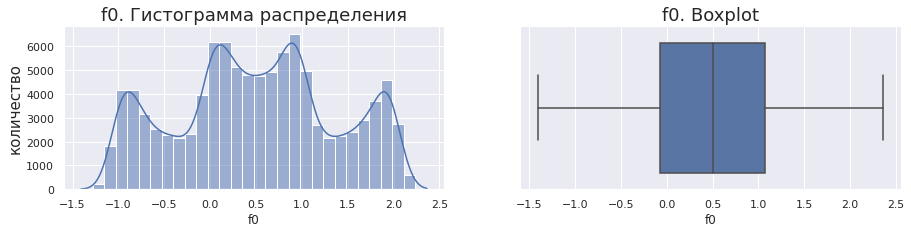

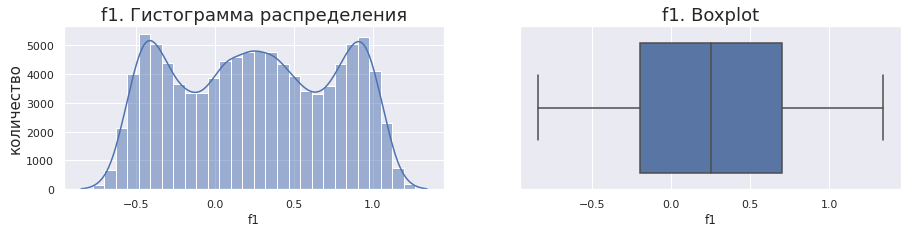

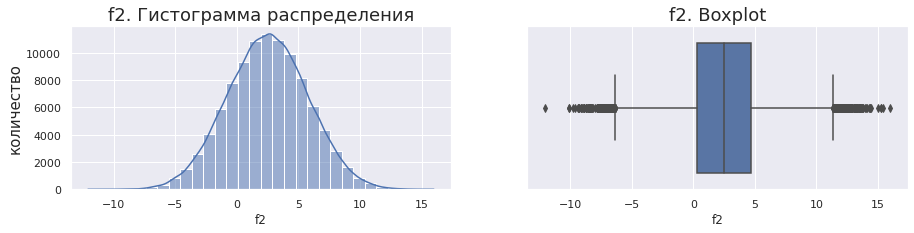

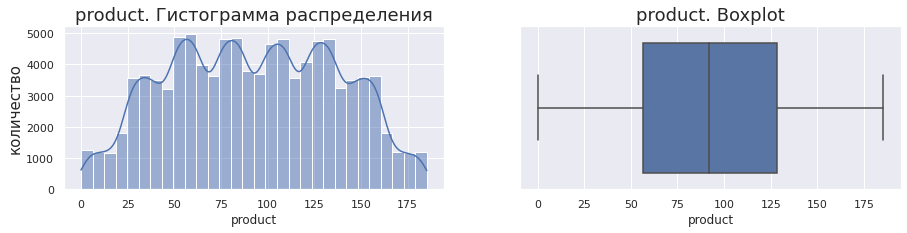

In [27]:
numerics = ['f0', 'f1', 'f2', 'product']
for column in numerics:
    show_hists(df_1[column], column, num_bins=30)

,f0,f1,f2,product
f0,1.000000,-0.440717,-0.003211,0.143504
f1,-0.440717,1.000000,0.001764,-0.192351
f2,-0.003211,0.001764,1.000000,0.483631
product,0.143504,-0.192351,0.483631,1.000000


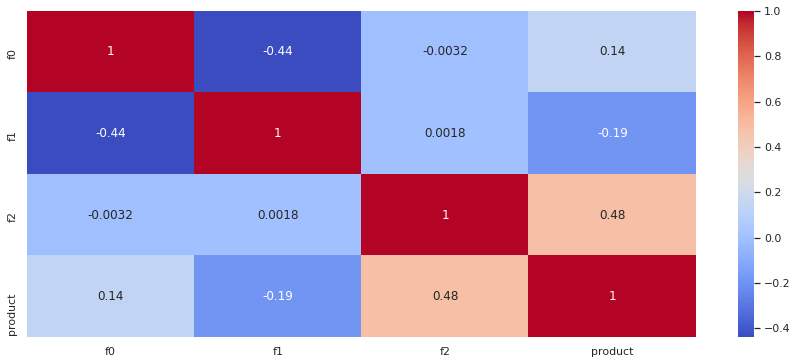

In [28]:
corr_matrix(df_1)

#### Для второго региона

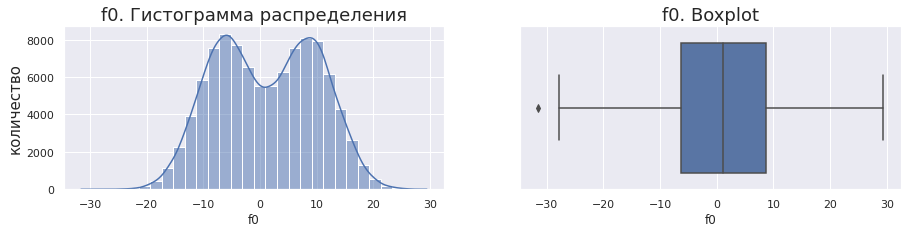

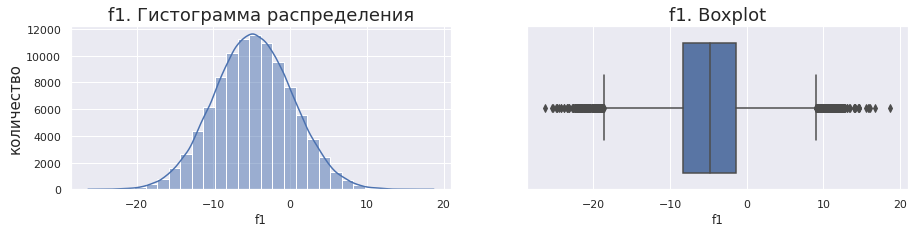

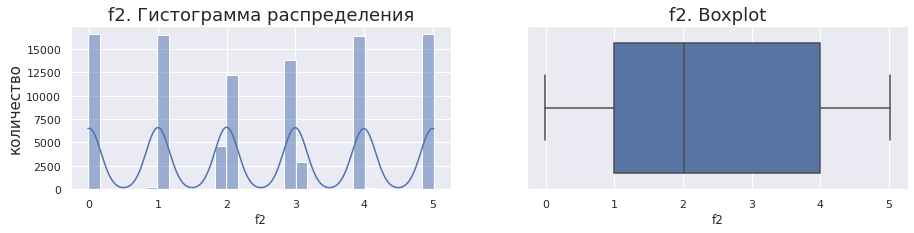

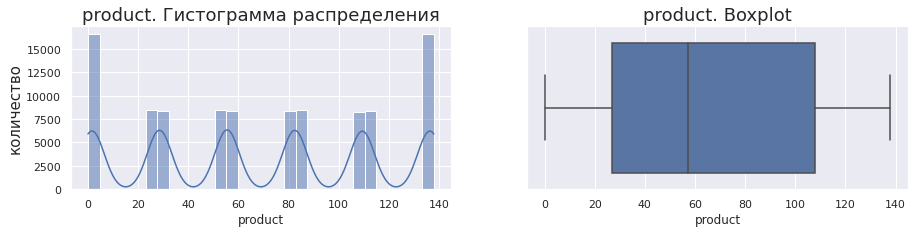

In [29]:
for column in numerics:
    show_hists(df_2[column], column, num_bins=30)

,f0,f1,f2,product
f0,1.000000,0.182279,-0.001810,-0.030523
f1,0.182279,1.000000,-0.002594,-0.010154
f2,-0.001810,-0.002594,1.000000,0.999397
product,-0.030523,-0.010154,0.999397,1.000000


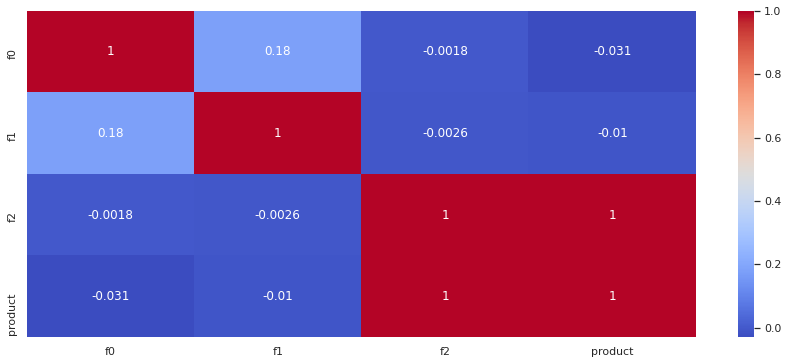

In [30]:
corr_matrix(df_2)

#### Для третьего региона

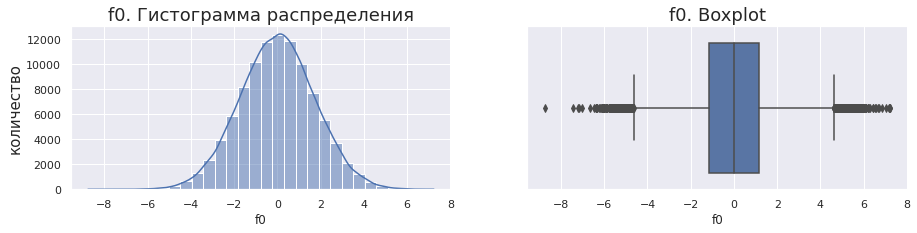

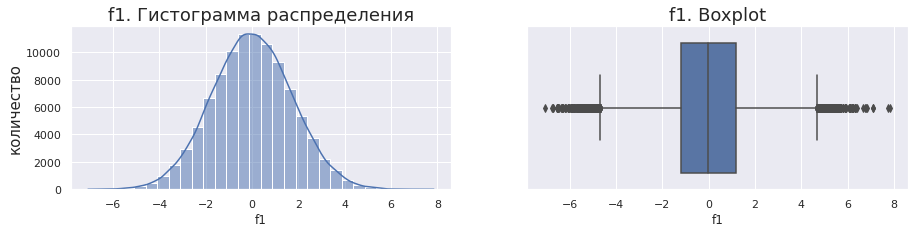

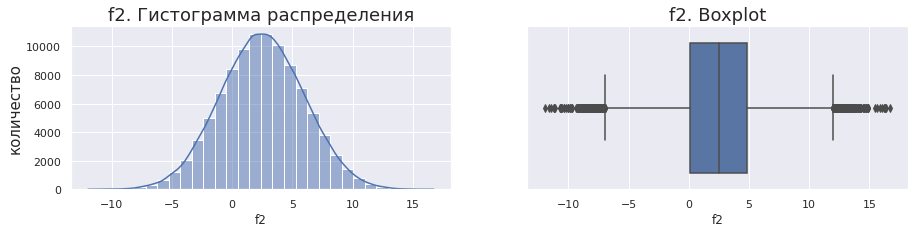

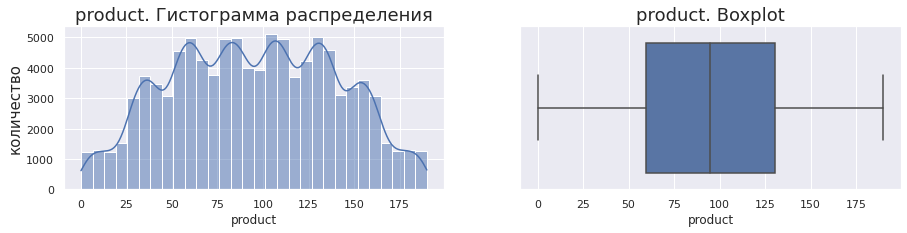

In [31]:
for column in numerics:
    show_hists(df_3[column], column, num_bins=30)

,f0,f1,f2,product
f0,1.000000,0.000506,-0.000452,-0.001978
f1,0.000506,1.000000,0.000753,-0.001055
f2,-0.000452,0.000753,1.000000,0.445867
product,-0.001978,-0.001055,0.445867,1.000000


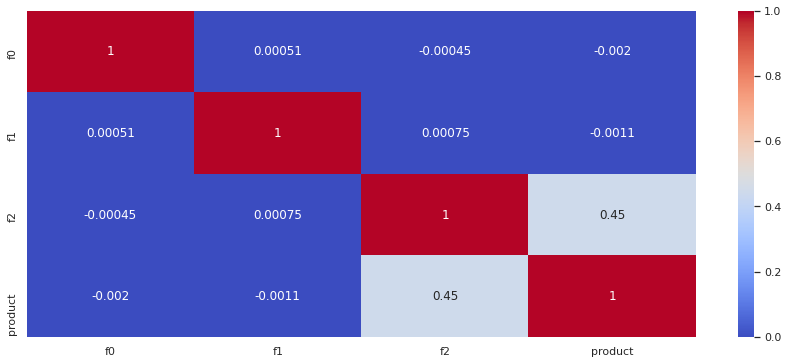

In [32]:
corr_matrix(df_3)

Большинсво параметров распределны не по нормально закону, но видно, что все парметры симметричны, что говорит о балансe признаков.

### Разъбиние данных на обучающую и валидационную выборки

Также необходимо удалить столбец 'id', т.к. он не играет роли при обучении

In [33]:
def split(data):
    
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']

    features_train, features_val, target_train, target_val = train_test_split(
        features, target, test_size=.25, random_state=12345)
    
    return features_train, features_val, target_train, target_val

In [34]:
features_train_1, features_val_1, target_train_1, target_val_1 = split(df_1)

In [35]:
features_train_2, features_val_2, target_train_2, target_val_2 = split(df_2)

In [36]:
features_train_3, features_val_3, target_train_3, target_val_3 = split(df_3)

print('Размер обучающей выборки параметров:', features_train_3.shape)
print('Размер обучающей выборки целевого парметра:', target_train_3.shape)
print('Размер валидационной выборки параметров:', features_val_3.shape)
print('Размер валидационной выборки целевого парметра:',target_val_3.shape)

Размер обучающей выборки параметров: (74997, 3)
Размер обучающей выборки целевого парметра: (74997,)
Размер валидационной выборки параметров: (24999, 3)
Размер валидационной выборки целевого парметра: (24999,)


Разбиние выполнено корректно

## Обучение и проверка модели

In [37]:
def model_line(features_train, target_train, features_val, target_val):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_val = model.predict(features_val)
    result = mean_squared_error(target_val, predictions_val)**0.5
    product_mean = predictions_val.mean()
    
    print('Средний запас предсказанного сырья:', product_mean)
    print('RMSE модели:', result)
    
    return predictions_val

### Первый регион 

In [38]:
predictions_val_1 = model_line(features_train_1, target_train_1, features_val_1, target_val_1)

Средний запас предсказанного сырья: 92.78915638280621
RMSE модели: 37.853527328872964


### Второй регион 

In [39]:
predictions_val_2 = model_line(features_train_2, target_train_2, features_val_2, target_val_2)

Средний запас предсказанного сырья: 69.17831957030432
RMSE модели: 0.892059264771703


### Третий регион 

In [40]:
predictions_val_3 = model_line(features_train_3, target_train_3, features_val_3, target_val_3)

Средний запас предсказанного сырья: 94.86572480562035
RMSE модели: 40.07585073246016


Видими, что у вторго региона сильно отличется среднее и корень из средней квадратической ошибки. Во втором регионе все данные о скважинах схожи, это видно из низкого показателя RMSE.

## Подготовка к расчёту прибыли

При разведке региона исследуюем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.
рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью

In [41]:
predictions_val_1 = pd.Series(predictions_val_1, index=target_val_1.index)
predictions_val_2 = pd.Series(predictions_val_2, index=target_val_2.index)
predictions_val_3 = pd.Series(predictions_val_3, index=target_val_3.index)

names = ['df_1', 'df_2', 'df_3']
predictions = [predictions_val_1, predictions_val_2, predictions_val_3]

break_even = BUDGET / (BARREL_PRICE * BEST_FOR_ML)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, predictions in zip(names, predictions):
    print()
    print(f'Средний запас в {name} регионе = {predictions.mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(predictions.loc[ lambda x : x > break_even]) / len(predictions):.2%}')
    print(f'Количество скважин в объёмом больше чем порог = {len(predictions.loc[ lambda x : x > break_even])}')


Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в df_1 регионе = 92.79 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 21.80%
Количество скважин в объёмом больше чем порог = 5450

Средний запас в df_2 регионе = 69.18 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 18.33%
Количество скважин в объёмом больше чем порог = 4583

Средний запас в df_3 регионе = 94.87 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 21.31%
Количество скважин в объёмом больше чем порог = 5327


Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей, по средним величинам уходим в минус, но есть точки и лучше. Для каждого региона около 20% точек будут окупаться

## Расчёт прибыли и рисков 

In [42]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)[:count]
    selected = target[probs_sorted.index]
    product = selected.sum()
    revenue = product * BARREL_PRICE
    return revenue - BUDGET

In [43]:
targets = {
    'df_1': [target_val_1, predictions_val_1],
    'df_2': [target_val_2, predictions_val_2],
    'df_3': [target_val_3, predictions_val_3],
}

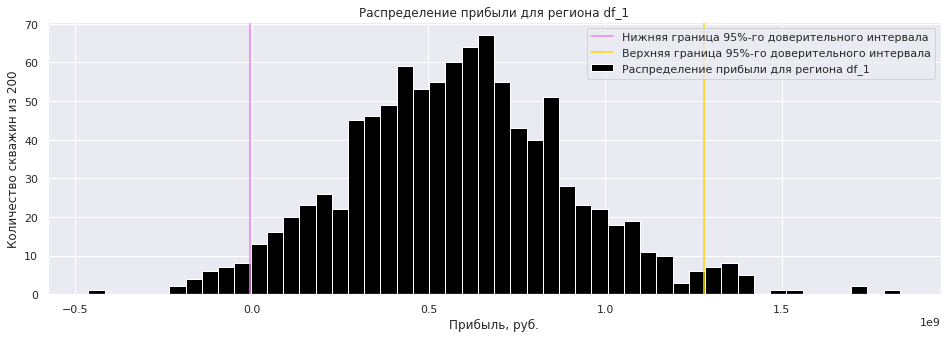


Для df_1 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 59 млн. рублей.
Доверительный интервал лежит между -1 - 128 млн. рублей.
Риск убытков составляет = 2.80%


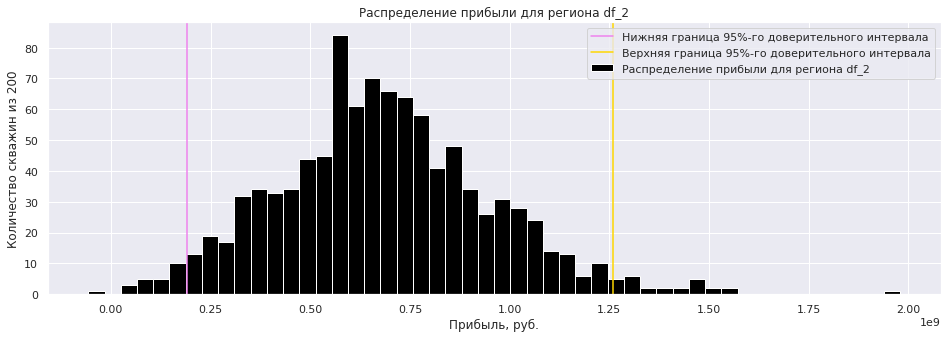


Для df_2 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 69 млн. рублей.
Доверительный интервал лежит между 19 - 126 млн. рублей.
Риск убытков составляет = 0.10%


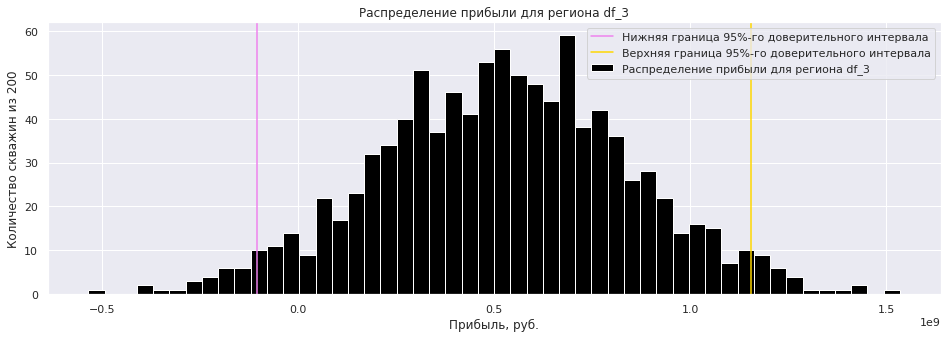


Для df_3 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 52 млн. рублей.
Доверительный интервал лежит между -11 - 116 млн. рублей.
Риск убытков составляет = 5.80%


In [44]:
state = np.random.RandomState(12345)

for name in targets:
    values = []
    for _ in range(1000):
        probs_subsample = targets[name][1].sample(POINTS, replace=True, random_state=state)
        target_subsample = targets[name][0][probs_subsample.index]
        values.append(profit(target_subsample, probs_subsample, BEST_FOR_ML))
        
    values = pd.Series(values)
        
    mean = values.mean() / 10e6
    lower = values.quantile(.025) / 10e6
    upper = values.quantile(.975) / 10e6
        
    risk = values.apply(lambda x: x < 0).sum() / len(values)
    

    values.hist(figsize=(16, 5), bins=50, color='black');
    plt.grid(True);
    plt.axvline(values.quantile(0.025), color='violet');
    plt.axvline(values.quantile(0.975), color='gold')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
        'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона {name}']);
    plt.xlabel('Прибыль, руб.');
    plt.ylabel('Количество скважин из 200');
    plt.title(f'Распределение прибыли для региона {name}');
    plt.show();

    print()
    print(f'Для {name} региона:')
    print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')

В регионе df2 ожидается наибольшая возможная прибыль в размере 69 млн. рублей при оценке модели.
Риск потерь минимальный - всего 0,1%, также во втором регионе.
Учитывая все факторы, можно порекомендовать регион df2 для разработки, так как он обладает наибольшей средней потенциальной прибылью и минимальными рисками.